In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("./data/usingXGBoost-train.csv")
test = pd.read_csv("./data/usingXGBoost-test.csv")

In [3]:
train.shape, test.shape

((7352, 563), (2947, 563))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [5]:
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [6]:
columns = train.columns
columns = columns.str.replace('[()]', '')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]', '')
train.columns = columns
test.columns = columns

In [7]:
columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [8]:
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
    for index, perplexity in enumerate(perplexities):
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('t-SNE을 활용한 시각화')
        df = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_data})
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, palette="Set1",
                   markers=['^', 'v', 's', 'o', '1', '2'])
        plt.title(f"perplexity : {perplexity} and max_iter : {n_iter}")
        img_name = img_name_prefix + f'_perp_{perplexity}_iter_{n_iter}.png'
        plt.savefig(img_name)
        plt.show()
        print('Done')

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.013s...
[t-SNE] Computed neighbors for 7352 samples in 0.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274336
[t-SNE] Computed conditional probabilities in 0.096s
[t-SNE] Iteration 50: error = 89.2966843, gradient norm = 0.0304375 (50 iterations in 1.180s)
[t-SNE] Iteration 100: error = 82.9642334, gradient norm = 0.0078799 (50 iterations in 0.766s)
[t-SNE] Iteration 150: error = 81.5928574, gradient norm = 0

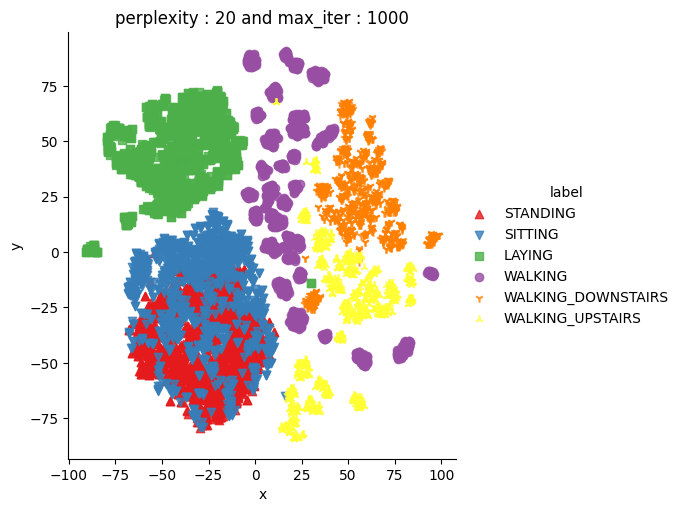

Done


In [9]:
X_pre_tsne = train.drop(['subject', 'Activity'], axis=1)
y_pre_tsne = train['Activity']
perform_tsne(X_data=X_pre_tsne, y_data=y_pre_tsne, perplexities=[20])

In [10]:
data = pd.concat([train, test])
data = train.sample(frac=1)
f_df = data.loc[:, data.columns.str.contains('^f|^s|^a|^A')]
t_df = data.loc[:, data.columns.str.contains('^t|^s|^a|^A')]
X = data.drop(['subject', 'Activity'], axis=1)
y = data['Activity']
X_f = f_df.drop(['subject', 'Activity'], axis=1)
y_f = f_df['Activity']
X_t = t_df.drop(['subject', 'Activity'], axis=1)
y_t = t_df['Activity']
# PCA를 사용해서 차원 축소
pca = PCA(n_components=0.99)
pca.fit(X)
x_reduced = pca.transform(X)
print(f'주판수 성분은 {X_f.shape[1]},  시간 성분은 {X.shape[1] - X_f.shape[1]}')
print(f'데이터의 특징은 {X.shape[1]}, PCA를 사용해서 축소된 성분은 {x_reduced.shape[1]}')

주판수 성분은 296,  시간 성분은 265
데이터의 특징은 561, PCA를 사용해서 축소된 성분은 155


In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_reduced, y, test_size=0.2, shuffle=True,
                                                                    random_state=42)
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, shuffle=True, random_state=42)
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, shuffle=True, random_state=42)

In [12]:
kernal_evals = dict()


def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='micro')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='micro')
    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='micro')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='micro')
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall,
                               test_recall]
    print(f"Training Accuracy {name} is {train_accuracy * 100},  Test Accuracy {name} is {test_accuracy * 100}")
    print(f"Training Precesion {name} is {train_precision * 100},  Test Accuracy {name} is {test_precision * 100}")
    print(f"Training Recall {name} is {train_recall * 100},  Test Accuracy {name} is {test_recall * 100}")

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=['LAYING', 'SITTING', 'STANDING', 'WALKING',
                                                                'DOWNSTAIRS', 'UPSTAIRS'])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)

c:\Users\sigma\works\K-Digital_2nd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy Logistic Regression is 99.2518279204217,  Test Accuracy Logistic Regression is 97.89259007477906
Training Precesion Logistic Regression is 99.2518279204217,  Test Accuracy Logistic Regression is 97.89259007477906
Training Recall Logistic Regression is 99.2518279204217,  Test Accuracy Logistic Regression is 97.89259007477906


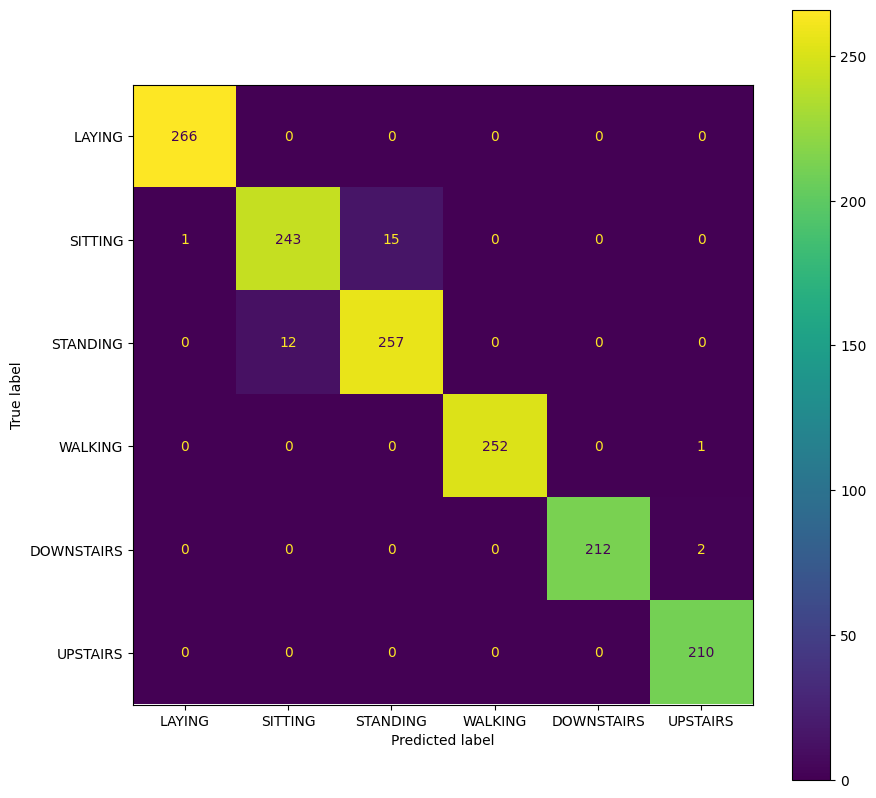

In [13]:
lr = LogisticRegression().fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)

Training Accuracy LinearDiscriminantAnalysis is 98.792722326135,  Test Accuracy LinearDiscriminantAnalysis is 97.82460910944936
Training Precesion LinearDiscriminantAnalysis is 98.792722326135,  Test Accuracy LinearDiscriminantAnalysis is 97.82460910944936
Training Recall LinearDiscriminantAnalysis is 98.792722326135,  Test Accuracy LinearDiscriminantAnalysis is 97.82460910944936


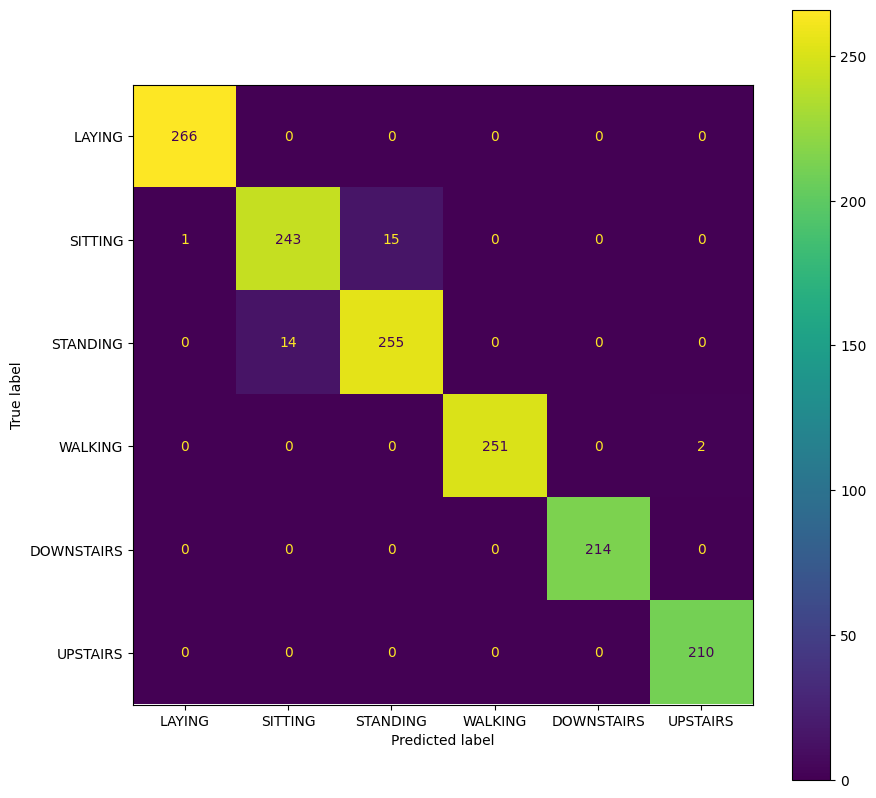

In [14]:
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
evaluate_classification(lda, "LinearDiscriminantAnalysis", x_train, x_test, y_train, y_test)

Training Accuracy KNeighborsClassifier is 95.8000340078218,  Test Accuracy KNeighborsClassifier is 93.33786539768865
Training Precesion KNeighborsClassifier is 95.8000340078218,  Test Accuracy KNeighborsClassifier is 93.33786539768865
Training Recall KNeighborsClassifier is 95.8000340078218,  Test Accuracy KNeighborsClassifier is 93.33786539768865


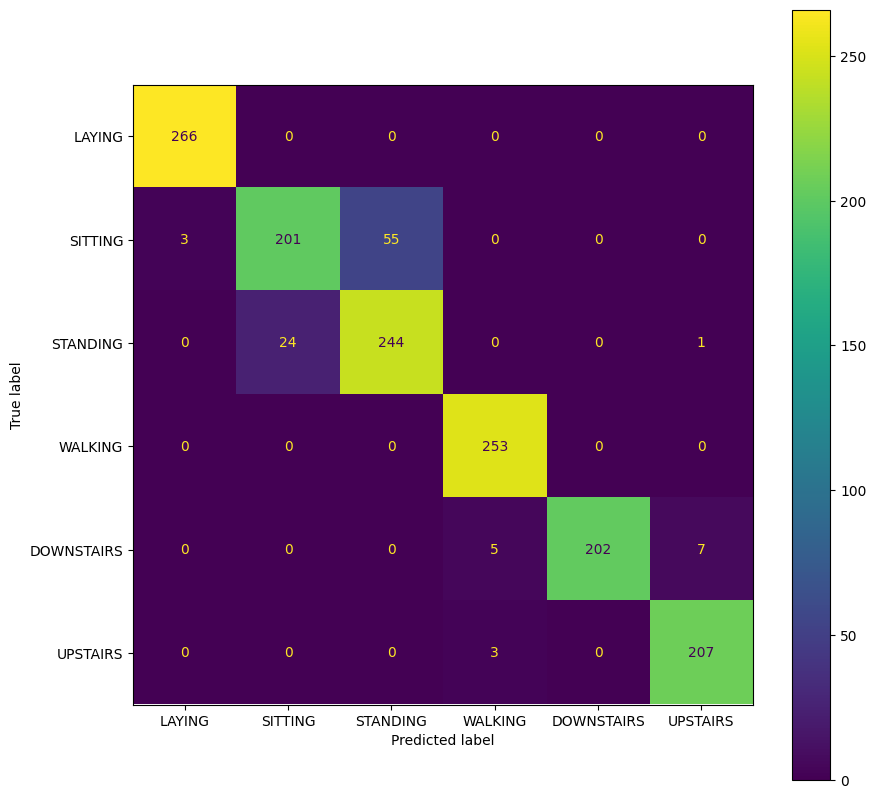

In [15]:
knn = KNeighborsClassifier(n_neighbors=30).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

Training Accuracy GaussianNB is 71.04233973813977,  Test Accuracy GaussianNB is 68.9326988443236
Training Precesion GaussianNB is 71.04233973813977,  Test Accuracy GaussianNB is 68.9326988443236
Training Recall GaussianNB is 71.04233973813977,  Test Accuracy GaussianNB is 68.9326988443236


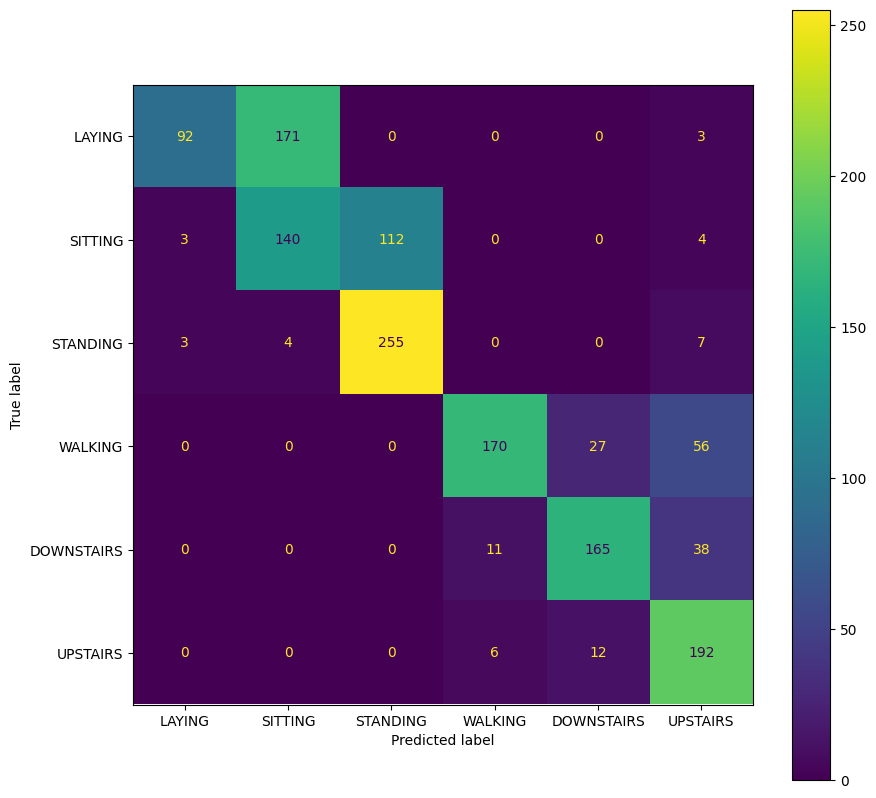

In [16]:
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)

c:\Users\sigma\works\K-Digital_2nd\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(LBasedImpl) is 99.5408944057133,  Test Accuracy Linear SVC(LBasedImpl) is 98.43643779741672
Training Precesion Linear SVC(LBasedImpl) is 99.5408944057133,  Test Accuracy Linear SVC(LBasedImpl) is 98.43643779741672
Training Recall Linear SVC(LBasedImpl) is 99.5408944057133,  Test Accuracy Linear SVC(LBasedImpl) is 98.43643779741672


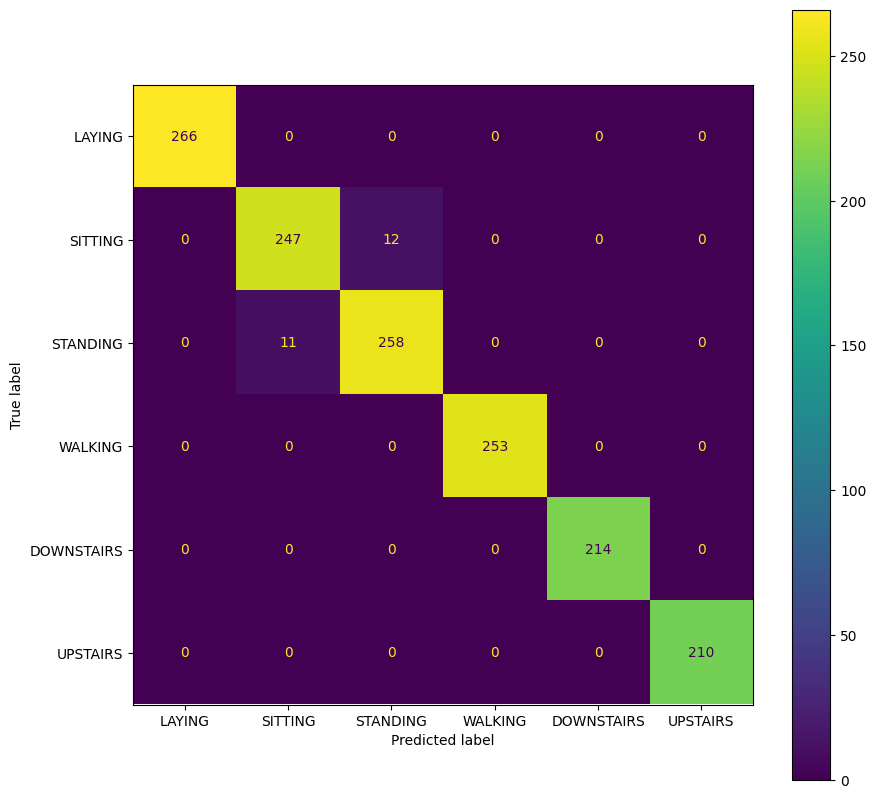

In [17]:
lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)

Training Accuracy RBF SVC is 97.61945247406904,  Test Accuracy RBF SVC is 97.00883752549286
Training Precesion RBF SVC is 97.61945247406904,  Test Accuracy RBF SVC is 97.00883752549286
Training Recall RBF SVC is 97.61945247406904,  Test Accuracy RBF SVC is 97.00883752549286


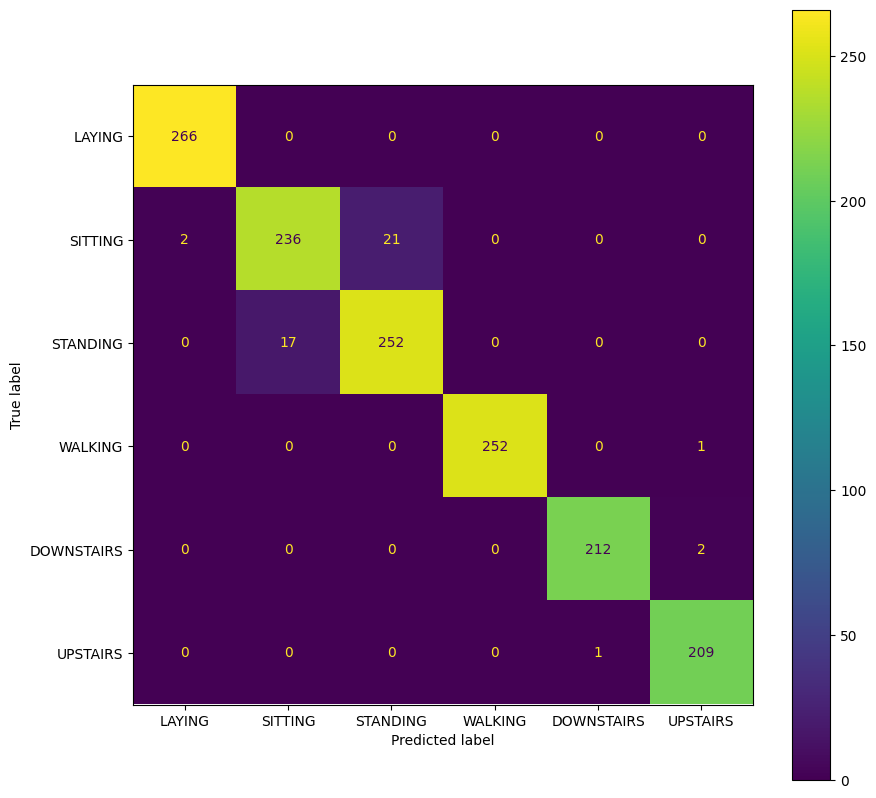

In [18]:
rbf = svm.SVC(kernel='rbf').fit(x_train, y_train)
evaluate_classification(rbf, "RBF SVC", x_train, x_test, y_train, y_test)

Training Accuracy DecisionTreeClassifier is 100.0,  Test Accuracy DecisionTreeClassifier is 93.94969408565602
Training Precesion DecisionTreeClassifier is 100.0,  Test Accuracy DecisionTreeClassifier is 93.94969408565602
Training Recall DecisionTreeClassifier is 100.0,  Test Accuracy DecisionTreeClassifier is 93.94969408565602


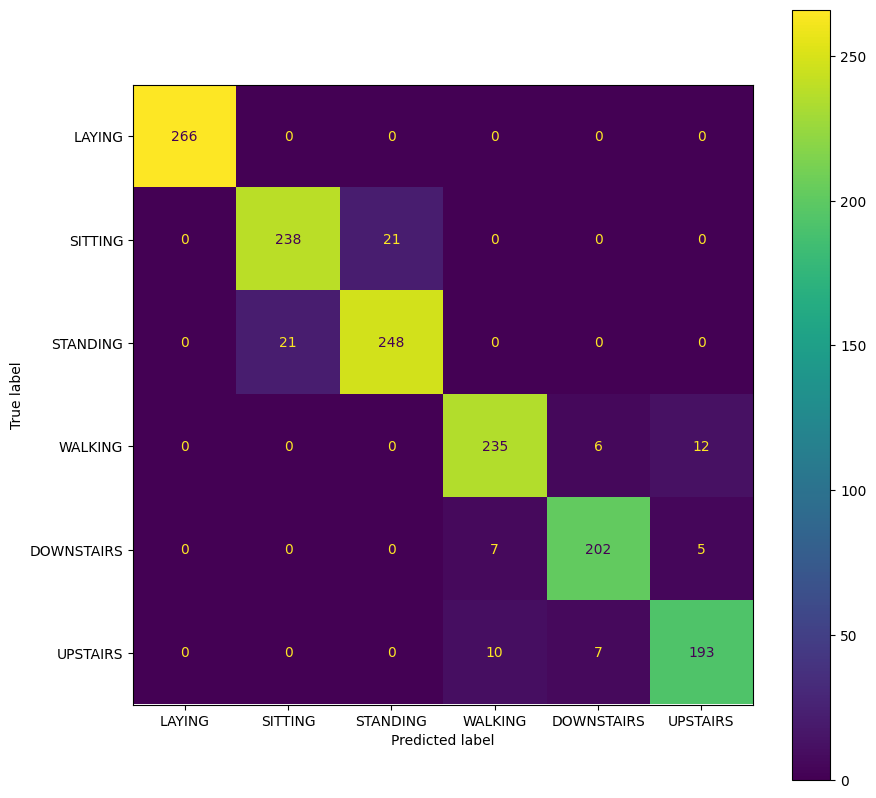

In [19]:
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

Training Accuracy RandomForestClassifier is 100.0,  Test Accuracy RandomForestClassifier is 97.75662814411965
Training Precesion RandomForestClassifier is 100.0,  Test Accuracy RandomForestClassifier is 97.75662814411965
Training Recall RandomForestClassifier is 100.0,  Test Accuracy RandomForestClassifier is 97.75662814411965


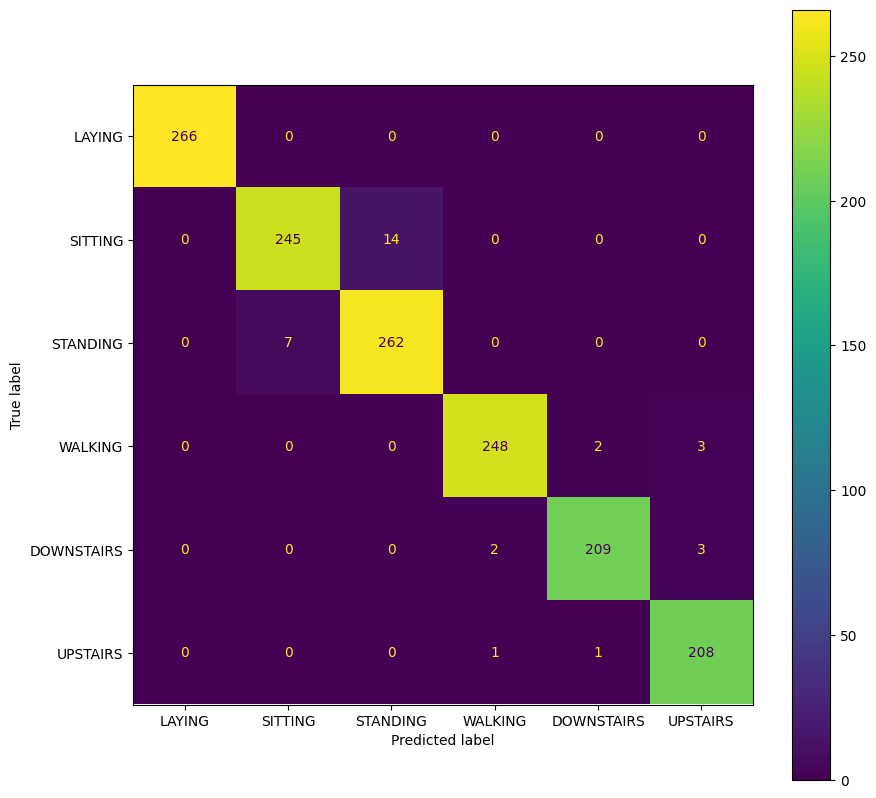

In [20]:
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

Training Accuracy XGBClassifier is 98.80972623703452,  Test Accuracy XGBClassifier is 96.94085656016316
Training Precesion XGBClassifier is 98.80972623703452,  Test Accuracy XGBClassifier is 96.94085656016316
Training Recall XGBClassifier is 98.80972623703452,  Test Accuracy XGBClassifier is 96.94085656016316


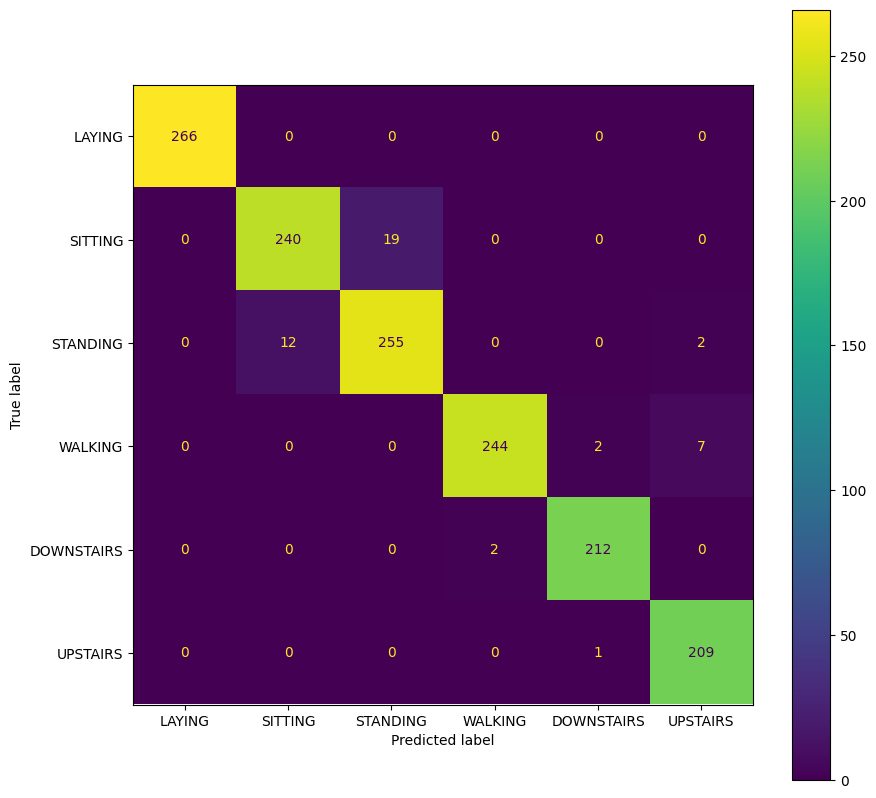

In [21]:
le = preprocessing.LabelEncoder().fit(y_train)
y_xgb_train = le.transform(y_train)
y_xgb_test = le.transform(y_test)
xgb_params = {'n_estimators': 100,
              'learning_rate': 0.2,
              'subsample': 0.927,
              'colsample_bytree': 0.88,
              'max_depth': 5,
              'booster': 'gbtree',
              'reg_lambda': 38,
              'reg_alpha': 32,
              'random_state': 12}
xgb = XGBClassifier(**xgb_params).fit(x_train, y_xgb_train)
evaluate_classification(xgb, "XGBClassifier", x_train, x_test, y_xgb_train, y_xgb_test)

C:\Users\sigma\AppData\Local\Temp\ipykernel_3148\2145220884.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


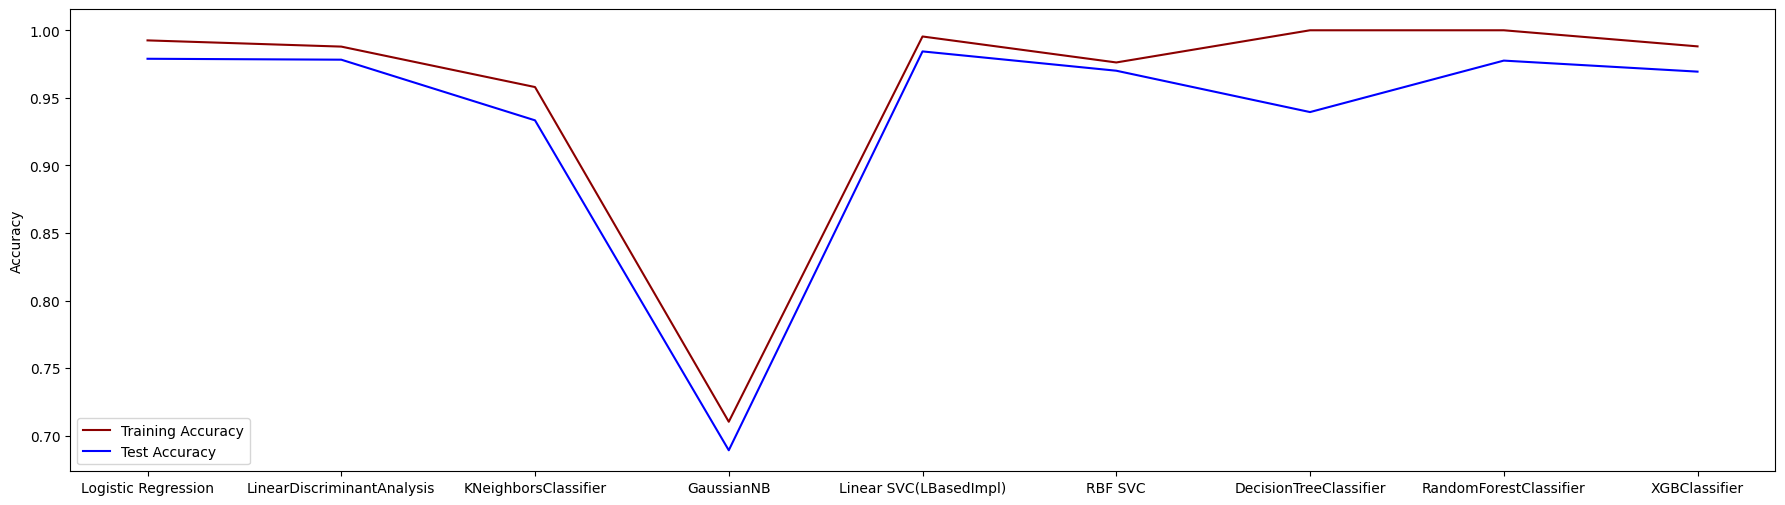

In [22]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(np.arange(len(keys)), [value[0] for value in values], color='darkred')
ax.plot(np.arange(len(keys)), [value[1] for value in values], color='b')
ax.legend(["Training Accuracy", "Test Accuracy"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Accuracy")
plt.show()

C:\Users\sigma\AppData\Local\Temp\ipykernel_3148\3211492091.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


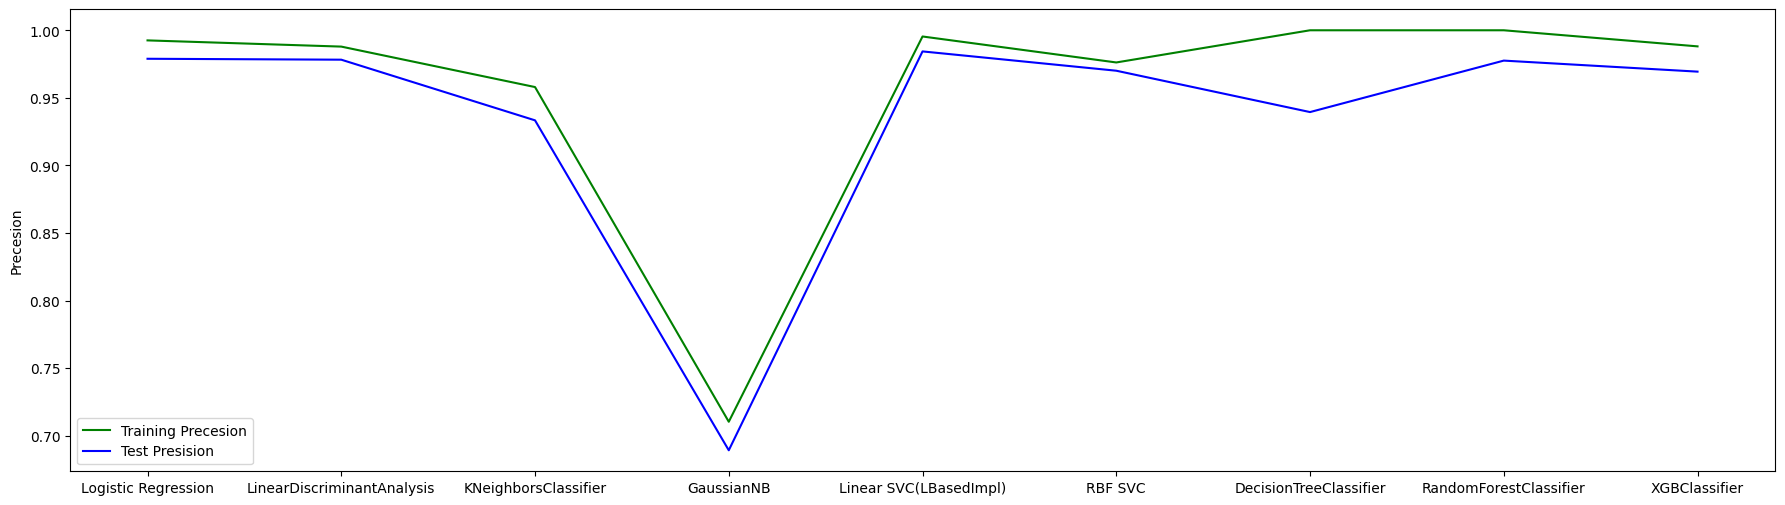

In [23]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(np.arange(len(keys)), [value[2] for value in values], color='g')
ax.plot(np.arange(len(keys)), [value[3] for value in values], color='b')
ax.legend(["Training Precesion", "Test Presision"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Precesion")
plt.show()

C:\Users\sigma\AppData\Local\Temp\ipykernel_3148\2734497504.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


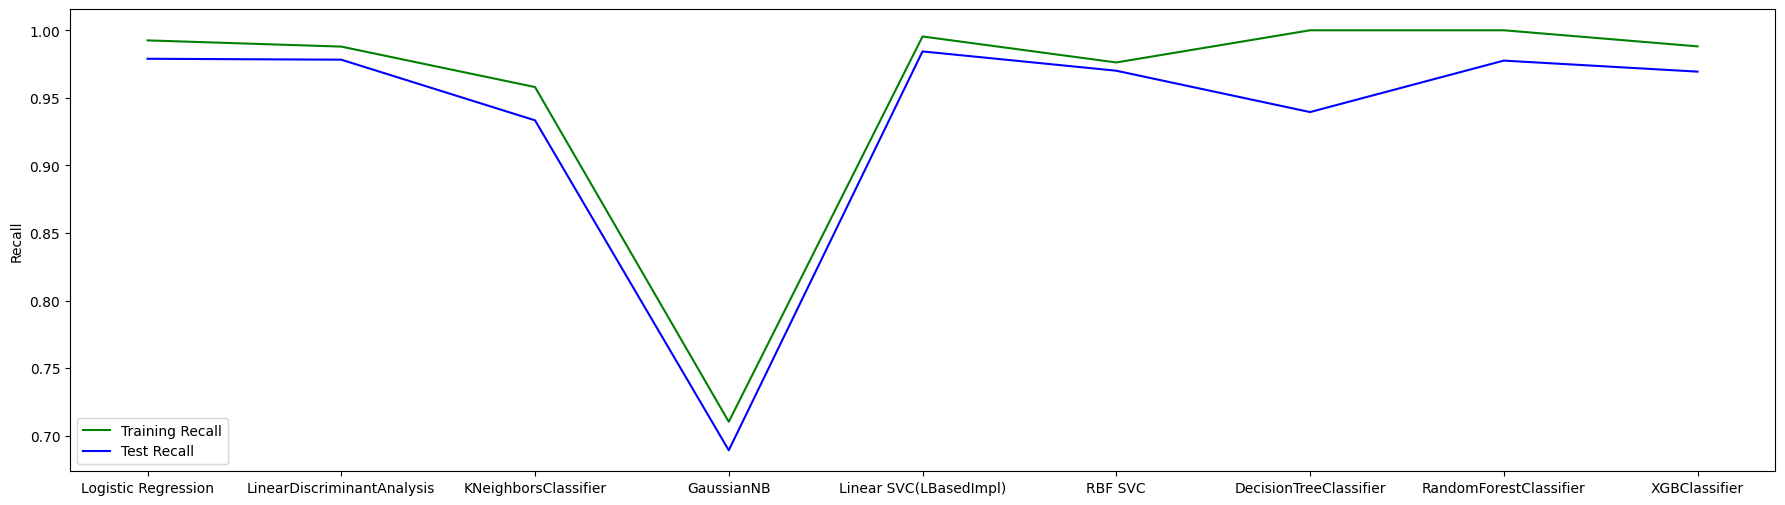

In [24]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(22, 6))
ax.plot(np.arange(len(keys)), [value[4] for value in values], color='g')
ax.plot(np.arange(len(keys)), [value[5] for value in values], color='b')
ax.legend(["Training Recall", "Test Recall"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Recall")
plt.show()

c:\Users\sigma\works\K-Digital_2nd\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(PCA) is 99.2518279204217,  Test Accuracy Linear SVC(PCA) is 98.43643779741672
Training Precesion Linear SVC(PCA) is 99.2518279204217,  Test Accuracy Linear SVC(PCA) is 98.43643779741672
Training Recall Linear SVC(PCA) is 99.2518279204217,  Test Accuracy Linear SVC(PCA) is 98.43643779741672


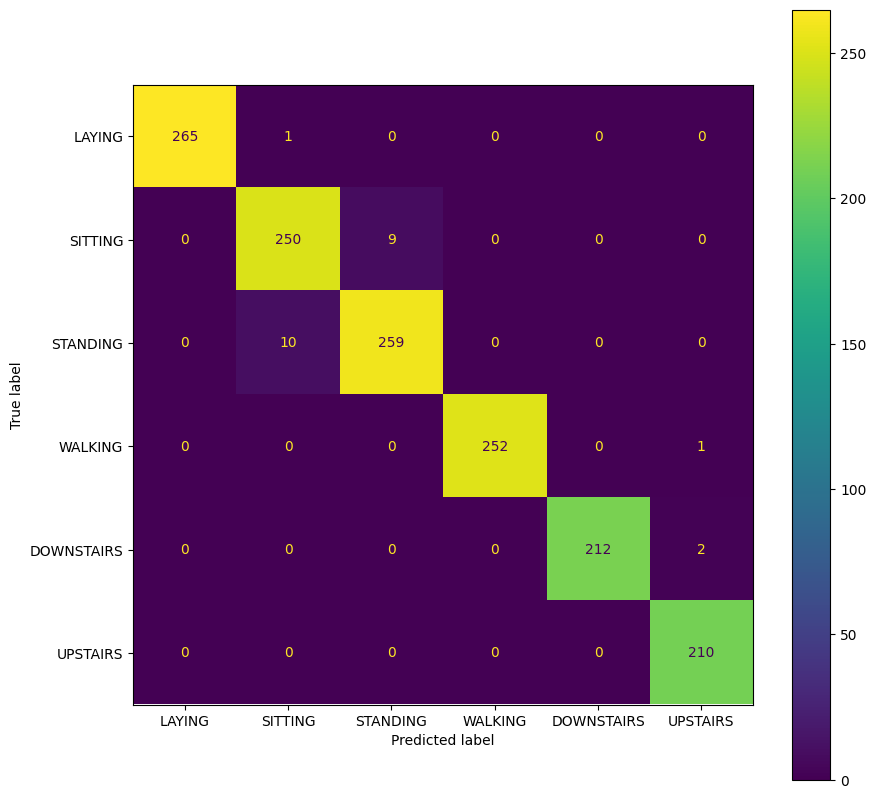

In [25]:
lin_svc_pca = svm.LinearSVC().fit(x_train_pca, y_train_pca)
evaluate_classification(lin_svc_pca, "Linear SVC(PCA)", x_train_pca, x_test_pca, y_train_pca, y_test_pca)

c:\Users\sigma\works\K-Digital_2nd\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(Frequency) is 97.95953069205918,  Test Accuracy Linear SVC(Frequency) is 96.26104690686607
Training Precesion Linear SVC(Frequency) is 97.95953069205918,  Test Accuracy Linear SVC(Frequency) is 96.26104690686607
Training Recall Linear SVC(Frequency) is 97.95953069205918,  Test Accuracy Linear SVC(Frequency) is 96.26104690686607


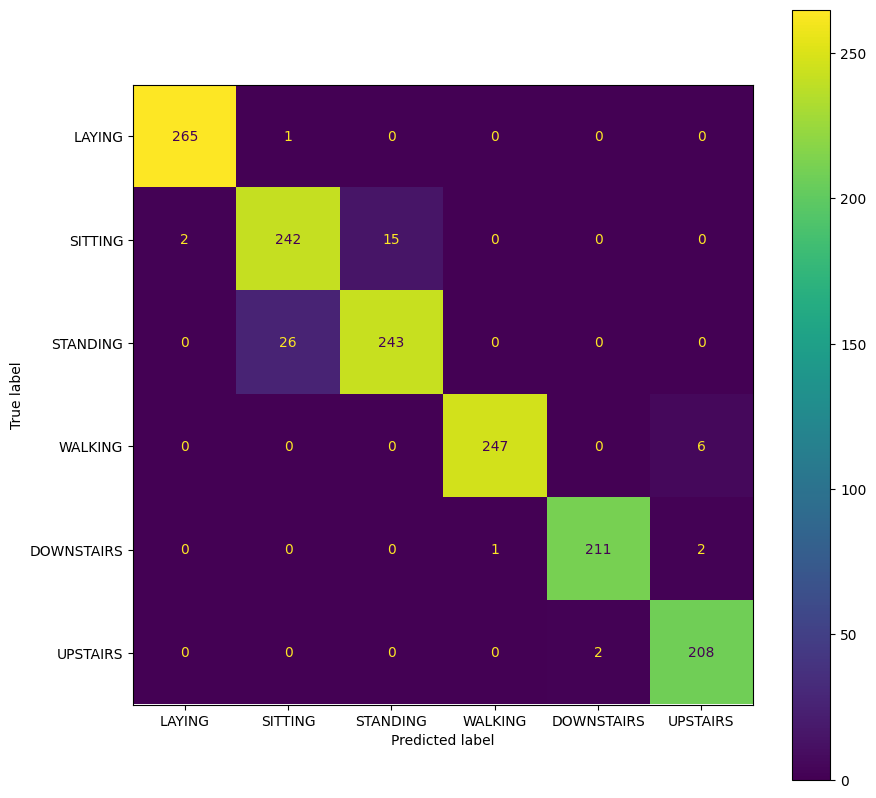

In [26]:
lin_svc_f = svm.LinearSVC().fit(x_train_f, y_train_f)
evaluate_classification(lin_svc_f, "Linear SVC(Frequency)", x_train_f, x_test_f, y_train_f, y_test_f)

c:\Users\sigma\works\K-Digital_2nd\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(Time) is 99.37085529671825,  Test Accuracy Linear SVC(Time) is 98.30047586675731
Training Precesion Linear SVC(Time) is 99.37085529671825,  Test Accuracy Linear SVC(Time) is 98.30047586675731
Training Recall Linear SVC(Time) is 99.37085529671825,  Test Accuracy Linear SVC(Time) is 98.30047586675731


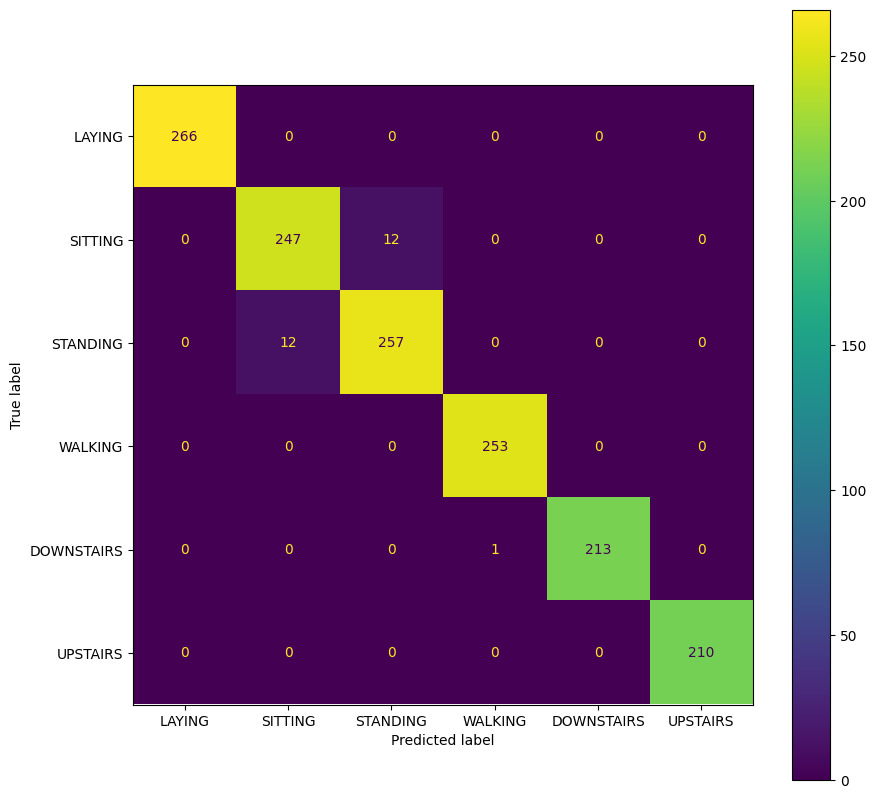

In [27]:
lin_svc_t = svm.LinearSVC().fit(x_train_t, y_train_t)
evaluate_classification(lin_svc_t, "Linear SVC(Time)", x_train_t, x_test_t, y_train_t, y_test_t)

Number of best for Anova is 180


c:\Users\sigma\works\K-Digital_2nd\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(K) is 98.758714504336,  Test Accuracy Linear SVC(K) is 98.16451393609789
Training Precesion Linear SVC(K) is 98.758714504336,  Test Accuracy Linear SVC(K) is 98.16451393609789
Training Recall Linear SVC(K) is 98.758714504336,  Test Accuracy Linear SVC(K) is 98.16451393609789


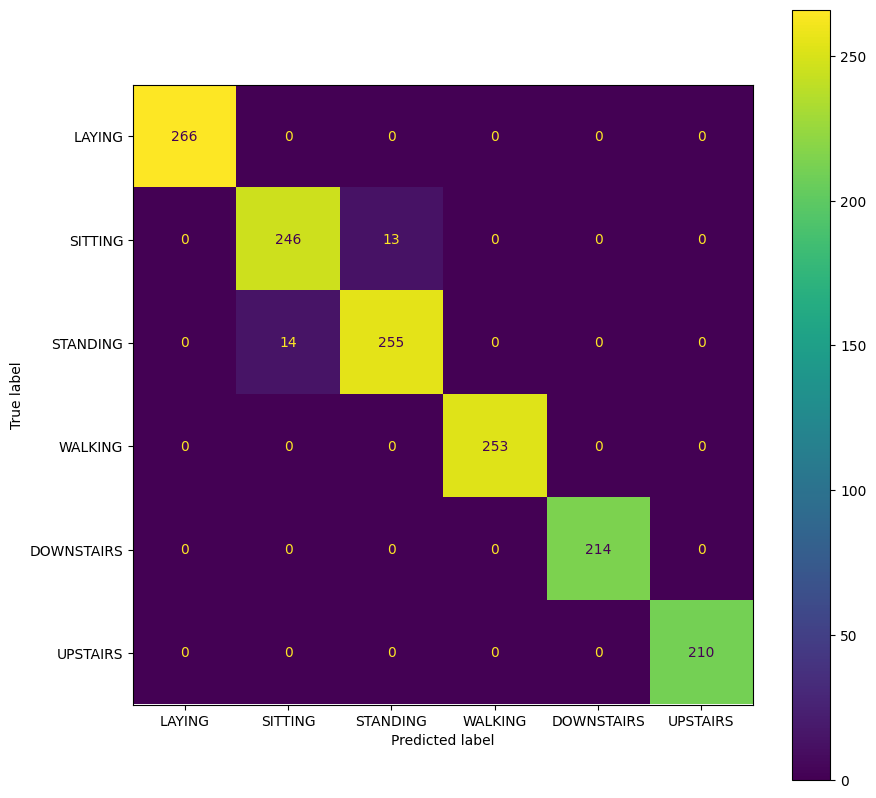

In [28]:
X_f_classif_k = SelectKBest(score_func=f_classif, k=180).fit_transform(X_t, y_t)
print('Number of best for Anova is {}'.format(X_f_classif_k.shape[1]))
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(X_f_classif_k, y, test_size=0.2, shuffle=True,
                                                            random_state=42)
lin_svc_k = svm.LinearSVC().fit(x_train_k, y_train_k)
evaluate_classification(lin_svc_k, "Linear SVC(K)", x_train_k, x_test_k, y_train_k, y_test_k)